In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import keras
from scipy import stats
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import OneHotEncoder
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from pandas.plotting import register_matplotlib_converters
from keras.models import model_from_json

print("---",tf.__version__)
clmns=['Gx','Gy','Gz','Class']
df = pd.read_csv('trainGyro.csv',header=None,names=clmns)
df = df.dropna()
print(df.shape)
df.head()

Using TensorFlow backend.


--- 2.2.0
(8160, 4)


,Gx,Gy,Gz,Class
0,-3.23,0.38,0.44,0
1,-2.85,0.03,-1.44,0
2,-3.30,-0.63,-0.77,0
3,-3.85,-0.84,0.50,0
4,-4.19,-0.25,-0.15,0


0    5943
1     791
3     782
2     644
Name: Class, dtype: int64


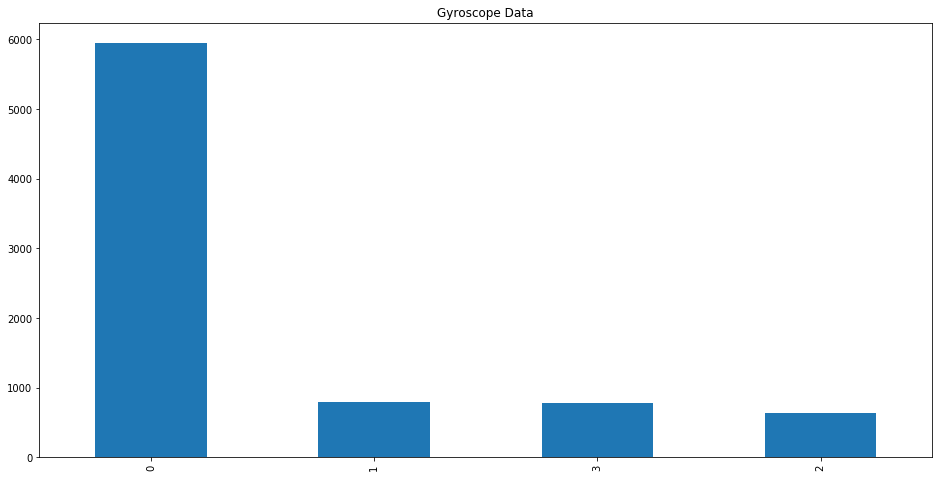

In [2]:
anaData = df['Class'].value_counts()
print(anaData)
anaData.plot(kind='bar',title='Gyroscope Data',figsize=(16,8))

In [3]:
def plot_activity(activity,df):
    rowActivity = (df['Class']==activity)
    data=df[rowActivity]
    data=data[['Gx','Gy','Gz']]
    data=data[:500]
    axis=data.plot(subplots=True, figsize=(16,12), title=activity) 

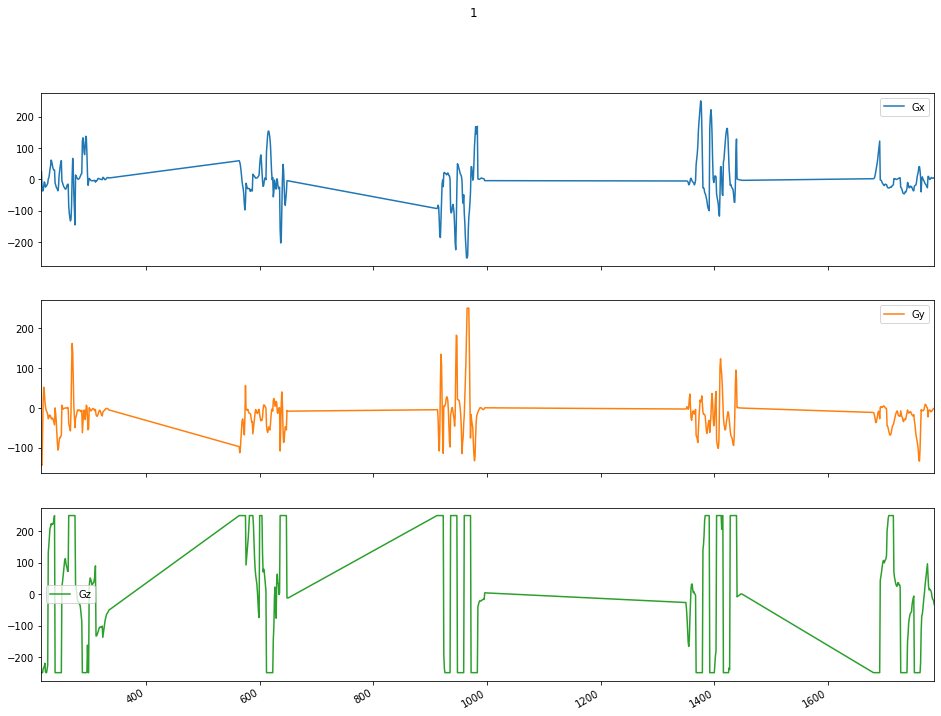

In [4]:
plot_activity(1,df)

In [5]:
df_train, df_test = train_test_split(df, test_size=0.1,shuffle=False)
print(df_train.shape)
df_train.head()


(7344, 4)


,Gx,Gy,Gz,Class
0,-3.23,0.38,0.44,0
1,-2.85,0.03,-1.44,0
2,-3.30,-0.63,-0.77,0
3,-3.85,-0.84,0.50,0
4,-4.19,-0.25,-0.15,0


In [6]:
scale_columns = ['Gx', 'Gy', 'Gz']
scaler = RobustScaler()
scaler = scaler.fit(df_train[scale_columns])
df_train.loc[:, scale_columns] = scaler.transform(
  df_train[scale_columns].to_numpy()
)
df_test.loc[:, scale_columns] = scaler.transform(
  df_test[scale_columns].to_numpy()
)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [7]:
def create_dataset(X, y, time_steps=1, step=1):
    Xs, ys = [], []
    for i in range(0, len(X) - time_steps, step):
        v = X.iloc[i:(i + time_steps)].values
        labels = y.iloc[i: i + time_steps]
        Xs.append(v)
        ys.append(stats.mode(labels)[0][0])
    return np.array(Xs), np.array(ys).reshape(-1, 1)

In [8]:
TIME_STEPS = 24
STEP = 1
X_train, y_train = create_dataset(
    df_train[['Gx', 'Gy', 'Gz']],
    df_train.Class,
    TIME_STEPS,
    STEP
)
X_test, y_test = create_dataset(
    df_test[['Gx', 'Gy', 'Gz']],
    df_test.Class,
    TIME_STEPS,
    STEP
)
print(X_train.shape, y_train.shape)


(7320, 24, 3) (7320, 1)


In [9]:
enc = OneHotEncoder(handle_unknown='ignore', sparse=False)
enc = enc.fit(y_train)
y_train = enc.transform(y_train)
y_test = enc.transform(y_test)
y_test.shape

(792, 4)

In [10]:
model = keras.Sequential()
model.add(
    keras.layers.Bidirectional(
      keras.layers.LSTM(
          units=128,
          input_shape=[X_train.shape[1], X_train.shape[2]]
      )
    )
)
model.add(keras.layers.Dropout(rate=0.2))
model.add(keras.layers.Dense(units=128, activation='relu'))
model.add(keras.layers.Dense(y_train.shape[1], activation='softmax'))
model.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['acc']
)

In [11]:
history = model.fit(
    X_train, y_train,
    epochs=20,
    batch_size=32,
    validation_split=0.1,
    shuffle=False
)

Train on 6588 samples, validate on 732 samples
Epoch 1/20
6588/6588 [==============================] - 16s 2ms/step - loss: 0.3330 - acc: 0.8981 - val_loss: 0.2812 - val_acc: 0.9372
Epoch 2/20
6588/6588 [==============================] - 16s 2ms/step - loss: 0.0688 - acc: 0.9772 - val_loss: 0.2222 - val_acc: 0.9631
Epoch 3/20
6588/6588 [==============================] - 18s 3ms/step - loss: 0.0376 - acc: 0.9848 - val_loss: 0.2708 - val_acc: 0.9454
Epoch 4/20
6588/6588 [==============================] - 18s 3ms/step - loss: 0.0302 - acc: 0.9909 - val_loss: 0.2171 - val_acc: 0.9262
Epoch 5/20
6588/6588 [==============================] - 13s 2ms/step - loss: 0.0312 - acc: 0.9880 - val_loss: 0.3173 - val_acc: 0.9085
Epoch 6/20
6588/6588 [==============================] - 9s 1ms/step - loss: 0.0287 - acc: 0.9895 - val_loss: 0.2241 - val_acc: 0.9262
Epoch 7/20
6588/6588 [==============================] - 11s 2ms/step - loss: 0.0227 - acc: 0.9918 - val_loss: 0.2427 - val_acc: 0.9208
Epoch 8/2

In [12]:
model.evaluate(X_test, y_test)

792/792 [==============================] - 0s 348us/step


[0.33099598715228157, 0.933080792427063]

In [13]:
y_pred = model.predict(X_test)
y_test.shape

(792, 4)

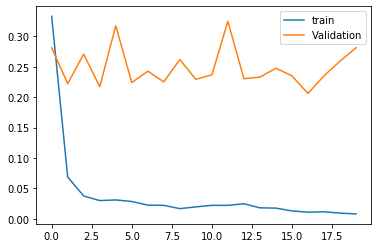

In [14]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'],label='train')
plt.plot(history.history['val_loss'],label='Validation')
plt.legend()

In [15]:
from sklearn.metrics import confusion_matrix

def plot_cm(y_true, y_pred, class_names):
  cm = confusion_matrix(y_true, y_pred)
  fig, ax = plt.subplots(figsize=(18, 16)) 
  ax = sns.heatmap(
      cm, 
      annot=True, 
      fmt="d", 
      cmap=sns.diverging_palette(220, 20, n=7),
      ax=ax
  )

  plt.ylabel('Actual')
  plt.xlabel('Predicted')
  ax.set_xticklabels(class_names)
  ax.set_yticklabels(class_names)
  b, t = plt.ylim() # discover the values for bottom and top
  b += 0.5 # Add 0.5 to the bottom
  t -= 0.5 # Subtract 0.5 from the top
  plt.ylim(b, t) # update the ylim(bottom, top) values
  plt.show() # ta-da!

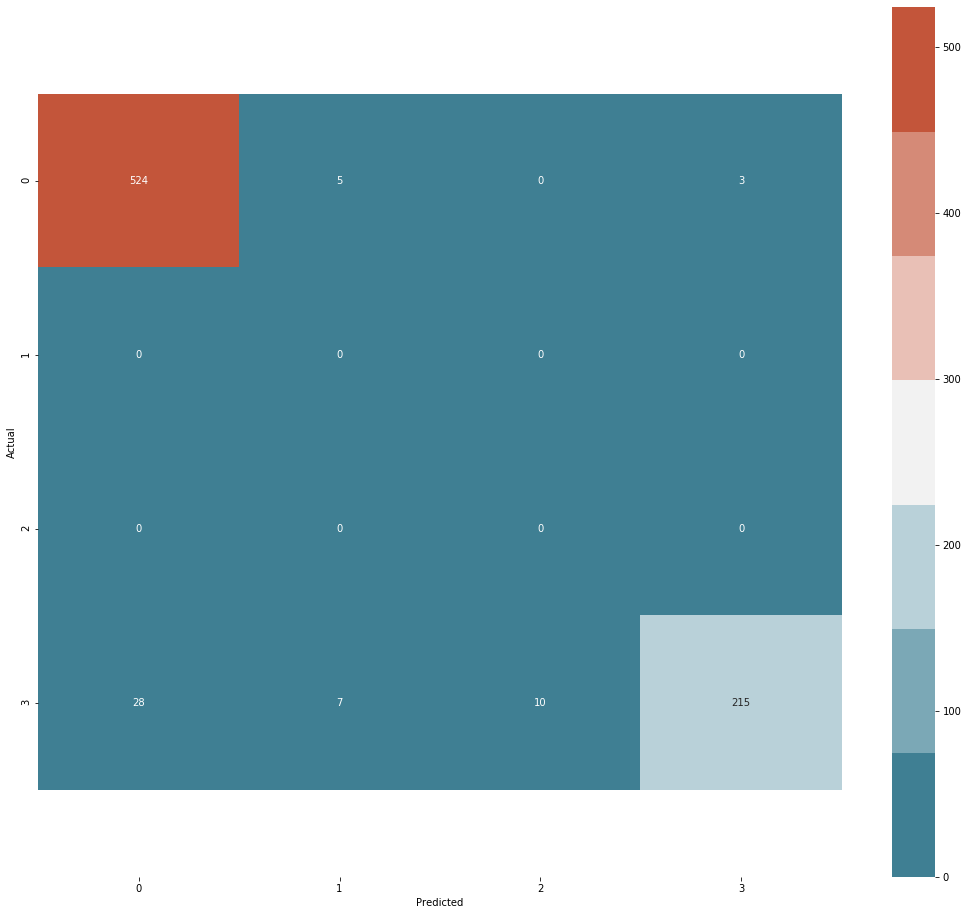

In [16]:
plot_cm(
  enc.inverse_transform(y_test),
  enc.inverse_transform(y_pred),
  enc.categories_[0]
)


In [17]:
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save("model.h5")

In [18]:
ml=keras.models.load_model("model.h5")

In [19]:
keras.__version__

'2.3.1'

In [20]:
tf.__version__


'2.2.0'

In [21]:
ts = np.array([
      [
        [
          "-2.64", 
          "0.10", 
          "-1.18"
        ], 
        [
          "-2.25", 
          "0.12", 
          "-1.69"
        ], 
        [
          "-2.36", 
          "0.37", 
          "-0.37"
        ], 
        [
          "-2.53", 
          "0.33", 
          "1.53"
        ], 
        [
          "-2.52", 
          "0.78", 
          "2.21"
        ], 
        [
          "-2.37", 
          "0.90", 
          "1.62"
        ], 
        [
          "-2.15", 
          "0.69", 
          "1.12"
        ], 
        [
          "-1.79", 
          "0.93", 
          "0.03"
        ], 
        [
          "-0.12", 
          "1.47", 
          "-0.40"
        ], 
        [
          "-2.48", 
          "0.28", 
          "0.78"
        ], 
        [
          "-2.33", 
          "0.76", 
          "1.88"
        ], 
        [
          "-1.79", 
          "1.19", 
          "2.73"
        ], 
        [
          "-2.47", 
          "0.31", 
          "0.88"
        ], 
        [
          "-2.47", 
          "0.27", 
          "1.05"
        ], 
        [
          "-2.39", 
          "0.21", 
          "1.34"
        ], 
        [
          "-2.76", 
          "0.10", 
          "1.31"
        ], 
        [
          "-2.61", 
          "0.04", 
          "1.21"
        ], 
        [
          "-2.73", 
          "0.05", 
          "0.60"
        ], 
        [
          "-2.44", 
          "0.17", 
          "0.50"
        ], 
        [
          "-2.60", 
          "-0.04", 
          "0.46"
        ], 
        [
          "-2.51", 
          "-0.05", 
          "0.69"
        ], 
        [
          "-2.50", 
          "-0.08", 
          "0.81"
        ], 
        [
          "-2.58", 
          "-0.04", 
          "0.66"
        ], 
        [
          "-2.37", 
          "0.04", 
          "0.54"
        ]
      ]
    ])
ts.shape

(1, 24, 3)

In [22]:
ml.predict(ts)

array([[9.9999976e-01, 1.1314218e-07, 1.3387300e-07, 1.6607961e-08]],
      dtype=float32)